In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import scipy.stats as stats
import scipy.integrate as integrate
import pymc as pm
from random import choices
import pickle
scale90=stats.norm.interval(.9)[1]
#%matplotlib notebook
import seaborn as sns
sns.set_style("whitegrid")
from scipy.interpolate import interp1d
import arviz as az


Define lambda and alpha values for likelihoods

In [2]:
lams=np.linspace(-5,5,1000)
alphas=np.linspace(-1,1,500)
Ses=np.linspace(0,10,100)

lamshape=len(lams)
alphashape=len(alphas)

Define useful functions

In [3]:
def PnegF2(F,fromstudy="annan"):
    if fromstudy=="annan":
        muF= - 4.0
        sigF=0.3
    elif fromstudy=="tierney":
        muF=-3.8
        sigF=0.23
    else:
        raise(TypeError,"fromstudy must be [annan,tierney]")

    #muT=-5.
    #sigT=1.
    return np.exp(-0.5*(F-muF)**2/sigF**2)*1/(np.sqrt(2*np.pi)*sigF)

def normlam(X,x=lams):
    return X/np.trapz(X,x=x)

def lam_to_S(lambda_pdf,debug=False):
    S_results=[]
    interp_lam=interp1d(lams, lambda_pdf, kind='cubic',fill_value=0,bounds_error=False)
    for S in Ses:
        if debug:
            print(S)
        integrand=lambda L: PnegF2(S*L)*interp_lam(L)* np.abs(L)

        S_results+=[integrate.quad(integrand,-np.inf,np.inf)[0]]
    return np.array(S_results)

# Observations of the Last Glacial Maximum
The uncertainty comes from uncertainty in the "true" value of $\Delta T$ and $\Delta F$.  Here, I will model them as the Tierney estimate
$$P_(\Delta T)(\Delta T) \sim \mathcal{N}(-6.1,0.2)$$ 
and the estimate of radiative forcing from the WCRP assessment 
$$P_(\Delta F) (\Delta F) \sim \mathcal{N}(-8.43,2)$$
We can later use a hierarchical model for these quantities.  Both the "true" temperature difference and forcing change are unobservable.  Instead, we have an ensemble of reconstructed temperatures and observationally-constrained modeled radiative forcing.  How should we combine these to get a best estimate of LGM temperature and forcing?  I think the best (at least simplest) way to do this is to treat each estimate as drawn from a distribution with unknown mean and standard deviation.  We can put priors on this distribution:
$$\mu | \sigma \sim \mathcal{N}(\mu_0,\sigma/\sqrt{\nu})$$
and
$$\sigma^2 \sim IG(k, 1/\sigma_0^2)$$
The posteriors will therefore depend on our prior beliefs in the "true" underlying value of these quantities: 

In [69]:
#Try to recreate what Tierney et al did.  I get close but not exactly their values
def get_tierney_forcing(nsamp_big=10000):
    muGHG=-2.48
    sigmaGHG=0.15

    #ice sheet https://royalsocietypublishing.org/doi/full/10.1098/rsta.2014.0424#d3e824
    #are error bars 1 or 2 sigma?!?!
    nsamp=1000
    pmip3_means=[-3.79,-4.9,-5.2,-4.57,-3.62]
    pmip2_means=[-2.59,-2.66,-3.23,-3.41,-3.48,-2.88]
    tierney_2020_mean=[-3.29]
    pmip3_sigmas=[0.1,0.1,0.3,0.3,0.1]
    pmip2_sigmas=np.tile(0.1,len(pmip2_means)).tolist()
    tierney_2020_sigma=[0.1]

    ice_means=pmip3_means+pmip2_means+tierney_2020_mean
    ice_sigmas=pmip3_sigmas+pmip2_sigmas+tierney_2020_sigma
    Rice=np.random.normal(ice_means[0],ice_sigmas[0],nsamp)
    for mu,sig in zip(ice_means[1:],ice_sigmas[1:]):
        Rice=np.append(Rice,np.random.normal(mu,sig,nsamp))


    #dust https://link.springer.com/article/10.1007/s40641-018-0100-7#Tab1
    Rdust=[-2,-1.1,-1,0.,.1,-.1,-.2,-.3,-.5]
    dust_kde=stats.gaussian_kde(Rdust)

    total_forcing=np.random.normal(muGHG,sigmaGHG,nsamp_big)\
    +np.random.choice(Rice,nsamp_big)\
    +dust_kde.resample(nsamp_big).flatten()


    return total_forcing
#tierney_forcing=get_tierney_forcing(nsamp_big=10000)
#tierney_kde=stats.gaussian_kde(tierney_forcing)

In [70]:
#use a lognormal distribution with reported 95% conficence interval in T20
s=(np.log(9.6)-np.log(5.2))/(stats.norm.ppf(.975)-stats.norm.ppf(.025))
samps=np.random.lognormal(np.log(6.8),s,10000)
tierney_kde=stats.gaussian_kde(-samps)

In [76]:
def PT(T,tempfrom="annan"):
    if tempfrom == "tierney":
        muT= -6.1
        sigT=0.2
    elif tempfrom  == "annan": 
        muT=-5.
        sigT=1.
    elif tempfrom=="meta":
        muT=-5.3
        sigT=0.35
    else:
        raise(TypeError,"tempfrom must be one of [meta,annan,tierney]")
    return np.exp(-0.5*(T-muT)**2/sigT**2)*1/(np.sqrt(2*np.pi)*sigT)
def PF(F,tempfrom="annan"):
    if tempfrom=="annan":
        muF=-8.43
        sigF=2.
        return np.exp(-0.5*(F-muF)**2/sigF**2)*1/(np.sqrt(2*np.pi)*sigF)
    elif tempfrom == "tierney": 
        return tierney_kde(F)
      
    elif tempfrom=="meta":
        #from Meta_Analysis.ipynb
        muF=-8.
        sigF=1.5

        return np.exp(-0.5*(F-muF)**2/sigF**2)*1/(np.sqrt(2*np.pi)*sigF)
    else:
        raise(TypeError,"tempfrom must be one of [meta,annan,tierney]")


In [72]:
def normT(tempfrom="tierney",nsamp=1000):
    if tempfrom == "tierney":
        muT= -6.1
        sigT=0.2
    else:
        
        muT=-5.
        sigT=1.
    return np.random.normal(muT,sigT,nsamp)
def normF(nsamp=1000):
    muF=-8.43
    sigF=2.

    #muT=-5.
    #sigT=1.
    return np.random.normal(muF,sigF,nsamp)

In [73]:
#Make arrays for plotting JPDF contours
dTsamp=np.linspace(-14,0,100)
dFsamp=np.linspace(-14,0,101)
GaussPlottierney=np.zeros((len(dTsamp),len(dFsamp)))
for i in range(len(dTsamp)):
    for j in range(len(dFsamp)):
        GaussPlottierney[i,j]=PT(dTsamp[i],tempfrom="tierney")*PF(dFsamp[j],tempfrom="tierney")
        
GaussPlotannan=np.zeros((len(dTsamp),len(dFsamp)))
for i in range(len(dTsamp)):
    for j in range(len(dFsamp)):
        GaussPlotannan[i,j]=PT(dTsamp[i],tempfrom="annan")*PF(dFsamp[j],tempfrom="annan")

In [9]:
import seaborn as sns
sns.set_style("whitegrid")

# Figure 1

# Last Glacial Maximum Likelihood
Let's assume (for now) the pattern effect during the last glacial maxiumum is zero (ie, the pattern effect arises only through diseqilibrium) but that there might be state dependence.  In that case, our model for the climate system is 
\begin{equation}
0 = \lambda \Delta T + \frac{\alpha}{2} \Delta T^2 + \Delta F \label{eq}
\end{equation}
and the likelihood is given by the line integral of the joint PDF over this curve:
$$\mathcal{L}(\lambda,\alpha | \Delta T, \Delta F) = \int_C P_{\Delta T}(\Delta T)  P_{\Delta F}(\Delta F) dl$$
which, given the simple model, is eqivalent to
$$\int_{-\infty}^{+\infty}P_{\Delta T}(x) P_{\Delta F}(-\frac{\alpha}{2} x^2 -\lambda x) \sqrt{1+(\alpha x+\lambda)^2} dx$$

Note that this neglects the relationship between $\Delta F$ and $F_{2xCO2}$ (the GHG forcing in the LGM is -0.57 $F_{2xCO2}$ ).  If we wanted to take this into account, we would need to do the double integral 
$$
\int \int P(x, y, -\beta y-\frac{\alpha}{2} x^2-\lambda x)\sqrt{(\alpha x + \lambda)^2+\beta^2+1}dxdy
$$
which is computationally tractable for S20 (since the PDF is Gaussian) but not for T20 (since the non-GHG forcing is nonGaussian).

In [10]:
def LGM_likelihood(lam,alpha,tempfrom="tierney"):
    
    #integrand=lambda x: PF(2*alpha*x**2- lam*x)*PT(x,tempfrom=tempfrom)* np.sqrt(1+(4*alpha*x-lam)**2)
    integrand=lambda x: PF(-alpha/2.*x**2- lam*x,tempfrom=tempfrom)*PT(x,tempfrom=tempfrom)* np.sqrt(1+(-alpha*x+-lam)**2)

    return integrate.quad(integrand,-np.inf,np.inf)[0]

In [11]:
LGM0=np.array([LGM_likelihood(x,0,tempfrom="annan") for x in lams])

In [12]:
LGMannan=np.array([LGM_likelihood(x,0,tempfrom="annan") for x in lams])
LGMtierney=np.array([LGM_likelihood(x,0,tempfrom="tierney") for x in lams])

In [13]:
# maximum likelihoods
maxlikt20=lams[np.argmax(LGMtierney)]
maxliks20=lams[np.argmax(LGMannan)]
print("max lik for T20: ",lams[np.argmax(LGMtierney)])
print("max lik for S20: ",lams[np.argmax(LGMannan)])

max lik for T20:  -1.1061061061061062
max lik for S20:  -1.7367367367367366


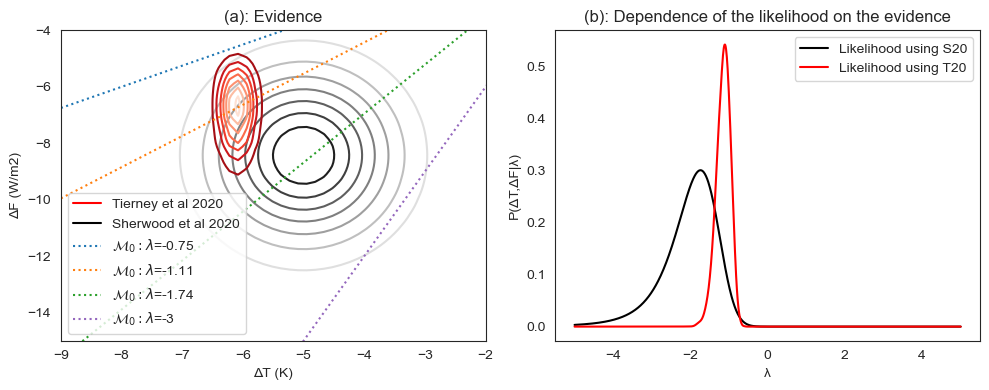

In [14]:
sns.set_style("white")
fig=plt.figure(figsize=(10,4))
#plt.contour(dFsamp,dTsamp,GaussPlotmeta,cmap=cm.Purples)
plt.subplot(1,2,1)
plt.contour(dTsamp,dFsamp, GaussPlotannan.T,cmap=cm.gray_r)
plt.contour(dTsamp,dFsamp, GaussPlottierney.T,cmap=cm.Reds_r)
x=plt.axhline(-5,c="r",label="Tierney et al 2020")
y=plt.axvline(-5,c="k",label="Sherwood et al 2020")


lams2=[-0.75,maxlikt20,maxliks20]
x1=np.arange(-9,-1,.01)
# afa=0.1
afa=0
#[plt.plot(x1,-lam*x1-afa/2*x1**2,label="λ="+str(np.round(lam,2))+", α="+str(afa)) for lam in lams2]
[plt.plot(x1,-lam*x1,label="$\mathcal{M}_{0}:\lambda$="+str(np.round(lam,2)),ls=":") for lam in lams2]

lam=-3
plt.plot(x1,-lam*x1,c=cm.tab10(4),label="$\mathcal{M}_{0}:\lambda$="+str(np.round(lam,2)),ls=":")

plt.ylabel("ΔF (W/m2)",fontsize=10)
plt.xlabel("ΔT (K)",fontsize=10)

plt.legend(fontsize=10,loc=3,ncol=1)
x.set_visible(False)
y.set_visible(False)
plt.xlim(-9,-2)
plt.ylim(-15,-4)
plt.title("(a): Evidence")

plt.subplot(1,2,2)
plt.plot(lams,LGMannan,c="k",label="Likelihood using S20")
plt.plot(lams,LGMtierney,c="r",label="Likelihood using T20")
plt.xlabel("λ",fontsize=10)
plt.ylabel("P(ΔT,ΔF|λ)")
plt.legend()
plt.title("(b): Dependence of the likelihood on the evidence")
plt.tight_layout()
#plt.savefig("FIGS/Fig1_final.png")

In [15]:
#Calculate the likelihood for different values of alpha
LGM_alpha_annan=np.zeros((5,len(lams)))
i=0
for a in [-0.1,-0.05,0,0.05,0.1]:
    LGM_alpha_annan[i]=np.array([LGM_likelihood(x,a,tempfrom="annan") for x in lams])
    i+=1
    
LGM_alpha_tierney=np.zeros((5,len(lams)))
i=0
for a in [-0.1,-0.05,0,0.05,0.1]:
    LGM_alpha_tierney[i]=np.array([LGM_likelihood(x,a,tempfrom="tierney") for x in lams])
    i+=1

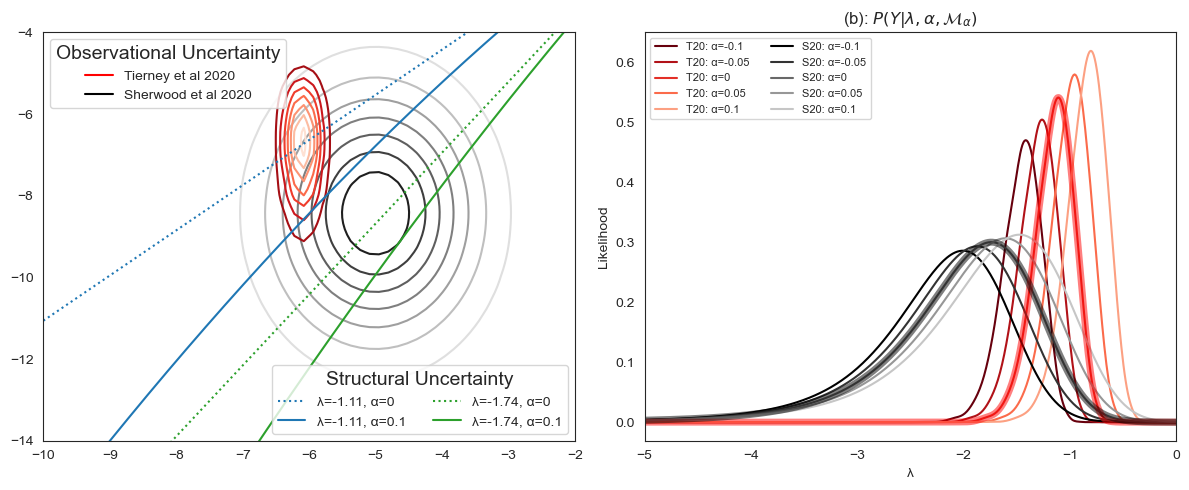

In [16]:
fig=plt.figure(figsize=(12,5))
plt.subplot(121)
plt.contour(dTsamp,dFsamp, GaussPlotannan.T,cmap=cm.gray_r)
plt.contour(dTsamp,dFsamp, GaussPlottierney.T,cmap=cm.Reds_r)
x=plt.axhline(-5,c="r",label="Tierney et al 2020")
y=plt.axvline(-5,c="k",label="Sherwood et al 2020")


lams2=[maxlikt20,maxliks20]
alllabels=[]
x1=np.arange(-10,-1,.01)
afas=[0,.1]
colors=[cm.tab10(0),cm.tab10(0),cm.tab10(2),cm.tab10(2)]
lstyles=[":","-",":","-"]
i=0
for lam in lams2:
    for afa in afas:
        lab="λ="+str(np.round(lam,2))+", α="+str(afa)
        alllabels+=[lab]
        plt.plot(x1,-lam*x1-afa/2*x1**2,label=lab,c=colors[i],ls=lstyles[i])
        i+=1



lines=plt.gca().get_lines()

leg1=plt.legend([lines[i] for i in [0,1]],\
           ["Tierney et al 2020", "Sherwood et al 2020"],\
           loc=2,title="Observational Uncertainty",title_fontsize=14)
leg2=plt.legend([lines[i] for i in [2,3,4,5]],\
           alllabels,\
           loc=4,title="Structural Uncertainty",\
                title_fontsize=14,ncol=2)

x.set_visible(False)
y.set_visible(False)
plt.xlim(-10,-2)
plt.ylim(-14,-4)
plt.gca().add_artist(leg1)



plt.subplot(122)
a=[-0.1,-0.05,0,0.05,0.1]
tmp=[plt.plot(lams,LGM_alpha_tierney[i],c=cm.Reds_r(i/6.),label="T20: α="+str(a[i])) for i in range(5)]
tmp=[plt.plot(lams,LGM_alpha_annan[i],c=cm.Greys_r(i/6.),label="S20: α="+str(a[i])) for i in range(5)]

plt.plot(lams,LGM_alpha_tierney[2],c="r",lw=5,alpha=.5)
plt.plot(lams,LGM_alpha_annan[2],c="k",lw=5,alpha=.5)
plt.legend(ncol=2,fontsize=8)
plt.xlabel("λ")
plt.ylabel("Likelihood")
plt.xlim(-5,0)
plt.title(r"(b): $P(Y|\lambda,\alpha,\mathcal{M}_{\alpha})$")
plt.tight_layout()
#plt.savefig("FIGS/Fig1_final.png")


# Prior on $\lambda$
Assume the process evidence gives rise to a prior on $\lambda$:
$$P(\lambda) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left\{-\frac{1}{2}\left(\frac{\lambda-\mu}{\sigma} \right)^2  \right\}$$
with $\mu=-1.3$ and $\sigma = 0.44$ as in the WCRP assessment.

In [17]:
mulam=-1.3
siglam=0.44

proc=np.exp(-0.5*(lams-mulam)**2/siglam**2)*1/(np.sqrt(2*np.pi)*siglam)

# Prior on $\alpha$
This is taken from the WCRP assessment paleo section.  "Most analyses suggest stronger net feedback for glacial
states (i.e., λ more negative, implying a lower sensitivity)."  So the assessment used
$$P(\alpha) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left\{-\frac{1}{2}\left(\frac{\alpha-\mu}{\sigma} \right)^2  \right\}$$
with $\mu=+0.1$ and $\sigma = 0.1$

In [18]:
alphaprior=np.exp(-0.5*(alphas-0.1)**2/(0.1**2))*1/(np.sqrt(2*np.pi)*0.1)

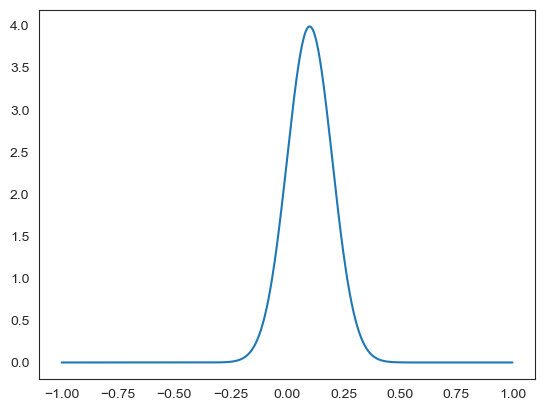

In [19]:
#Check: yes, it looks right
plt.plot(alphas,alphaprior)

## Joint PDF for LGM
Generate the joint likelihood for various values of $\lambda$ and $\alpha$.  Note that these are not samples- we're just integrating the joint PDF for the temperature and forcing changes over the curve defined by the energy balance model with state dependence.

In [20]:
import datetime


In [21]:
#This takes a long time because it's doing line integrals over 1000*500 points
generate_joint_PDF=False
pickle_it=False
if generate_joint_PDF:
    JPDF_tierney=np.zeros((lamshape,alphashape))
    JPDF_annan=np.zeros((lamshape,alphashape))
    for i in range(lamshape):
        for j in range(alphashape):
            JPDF_tierney[i,j]=LGM_likelihood(lams[i],alphas[j],tempfrom="tierney")
            JPDF_annan[i,j]=LGM_likelihood(lams[i],alphas[j],tempfrom="annan")
else:
    
    #with open("PICKLED/LGM_JPDF_tierney_05312022.pkl","rb") as picklefile:
    with open("PICKLED/LGM_JPDF_tierney_CURRENT.pkl", "rb") as picklefile:
        JPDF_tierney=pickle.load(picklefile)
    #with open("PICKLED/LGM_JPDF_annan_05312022.pkl","rb") as picklefile:
    with open("PICKLED/LGM_JPDF_annan_CURRENT.pkl", "rb") as picklefile:
        JPDF_annan=pickle.load(picklefile)

if pickle_it:
    today=datetime.date.today().strftime("%m%d%Y")
    with open("PICKLED/LGM_JPDF_tierney_"+today+".pkl","wb") as picklefile:
        pickle.dump(JPDF_tierney,picklefile)
    with open("PICKLED/LGM_JPDF_annan_"+today+".pkl","wb") as picklefile:
        pickle.dump(JPDF_annan,picklefile)

# Uniform priors on all parameters
If we don't know anything about either the feedbacks or the state dependence, large values of alpha are favored.

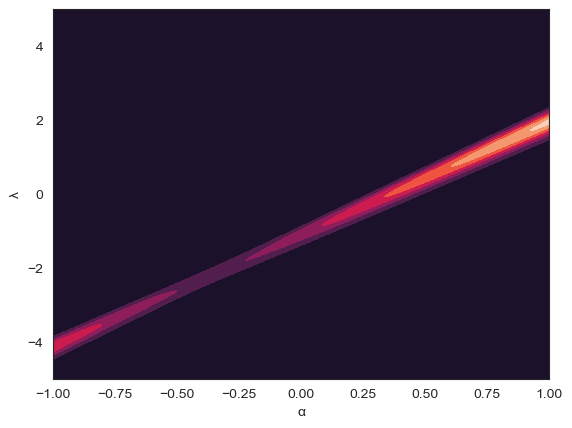

In [22]:
plt.figure()
plt.contourf(alphas,lams,JPDF_tierney)
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

How much do priors on alpha matter to our eventual estimate?  A lot, obviously.  You have to know something about the LGM in order to derive any information from it.

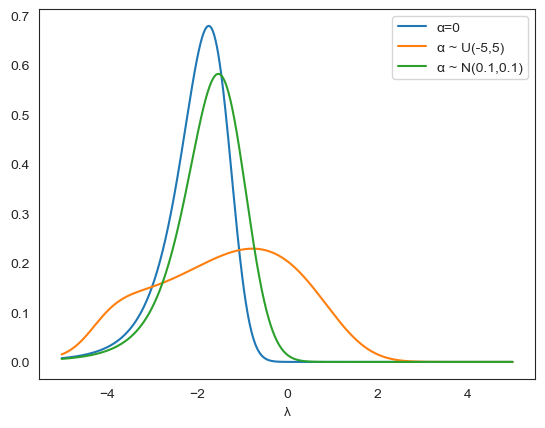

In [23]:
# Marginalizing over alpha with uniform and Gaussian priors
plt.figure()
plt.plot(lams,normlam(LGM0),label="α=0")
plt.plot(lams,normlam(np.sum(JPDF_annan,axis=1)),label="α ~ U(-5,5)")
plt.plot(lams,normlam(np.dot(JPDF_annan,alphaprior)),label="α ~ N(0.1,0.1)")
plt.xlabel("λ")
plt.legend()

In [24]:
lams[np.argmax(np.dot(JPDF_annan,alphaprior))]

-1.5265265265265264

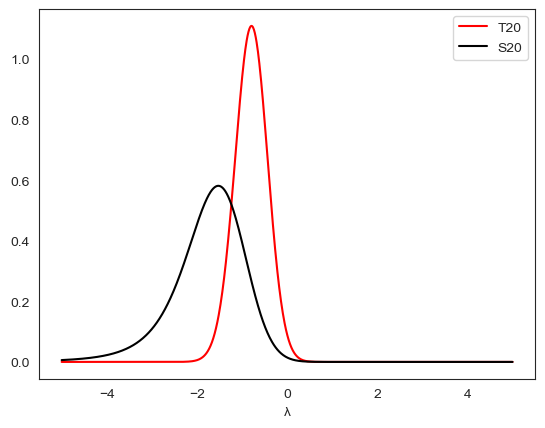

In [25]:
#difference between Tierney and Annan using the same model and same priors (Gaussian on alpha, uniform on lambda)
plt.figure()
plt.plot(lams,normlam(np.dot(JPDF_tierney,alphaprior)),label="T20",color="r")
plt.plot(lams,normlam(np.dot(JPDF_annan,alphaprior)),label="S20",color="k")
#
plt.xlabel("λ")
plt.legend()

# Joint posteriors for the parameters 
Here's how the joint posterior depends on the priors used

In [26]:




cplt_tierney = lambda X: plt.contour(alphas, lams, X/np.max(X),np.linspace(.01,1,10),cmap=cm.Reds )
cplt_annan = lambda X: plt.contour(alphas, lams, X/np.max(X),np.linspace(.01,1,10),cmap=cm.gray_r )


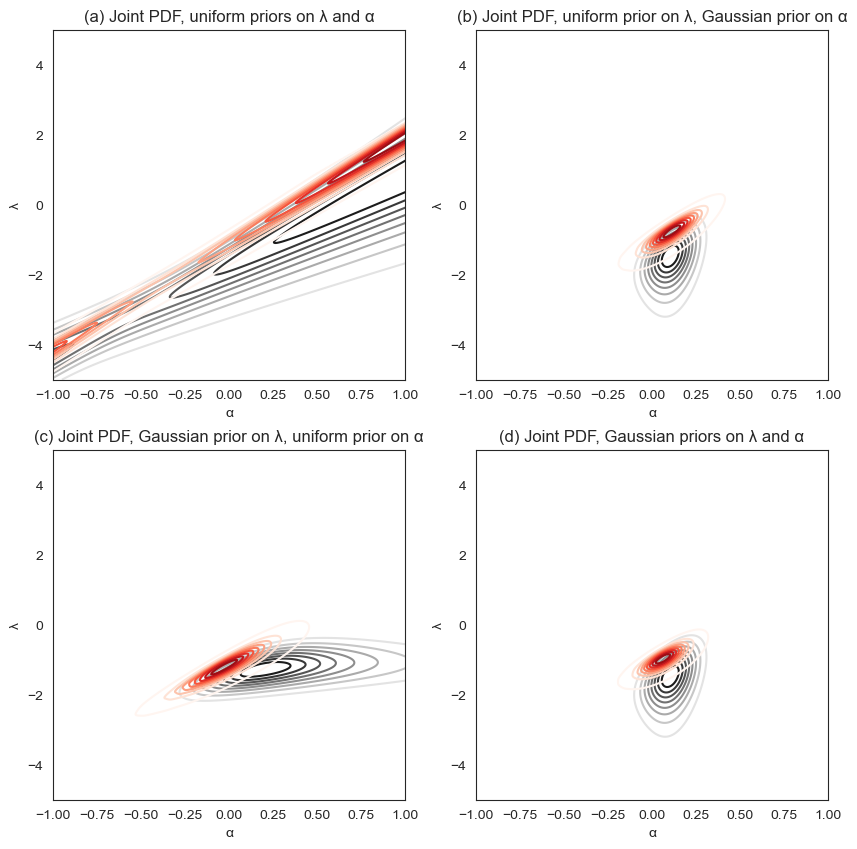

In [27]:
justproc=np.tile(proc,len(alphas)).reshape(len(alphas),len(proc)).T
justalpha=np.tile(alphaprior,len(lams)).reshape(len(lams),len(alphas))

plt.figure(figsize=(10,10))
ax=plt.subplot(2,2,1)

cplt_annan(JPDF_annan)
cplt_tierney(JPDF_tierney)
#plt.colorbar()
plt.title("(a) Joint PDF, uniform priors on λ and α")
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,3)

cplt_annan(JPDF_annan*justproc)
cplt_tierney(JPDF_tierney*justproc)
plt.title("(c) Joint PDF, Gaussian prior on λ, uniform prior on α")
#plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,2)
cplt_annan(justalpha*JPDF_annan)
cplt_tierney(justalpha*JPDF_tierney)

plt.title("(b) Joint PDF, uniform prior on λ, Gaussian prior on α")
#plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,4)
cplt_annan(justalpha*JPDF_annan)
cplt_tierney(justalpha*JPDF_tierney*justproc)

plt.title("(d) Joint PDF, Gaussian priors on λ and α")
#plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

#plt.savefig("FIGS/ParameterUncertainty.png")

In [28]:
Ps=np.dot(JPDF_annan,alphaprior)/np.sum(np.dot(JPDF_annan,alphaprior))
F2samp=np.random.normal(4,0.3,1000)
lamsamp=np.random.choice(lams,size=1000,p=Ps)
print(np.percentile(-F2samp/lamsamp,2.5))
print(np.percentile(-F2samp/lamsamp,97.5))

1.0235649175598491
7.827804926145763


In [ ]:
# now let's do the meta analysis 


In [29]:
with open("PICKLED/LGM_JPDF_meta_CURRENT.pkl","rb") as picklefile:
    JPDF_meta=pickle.load(picklefile)

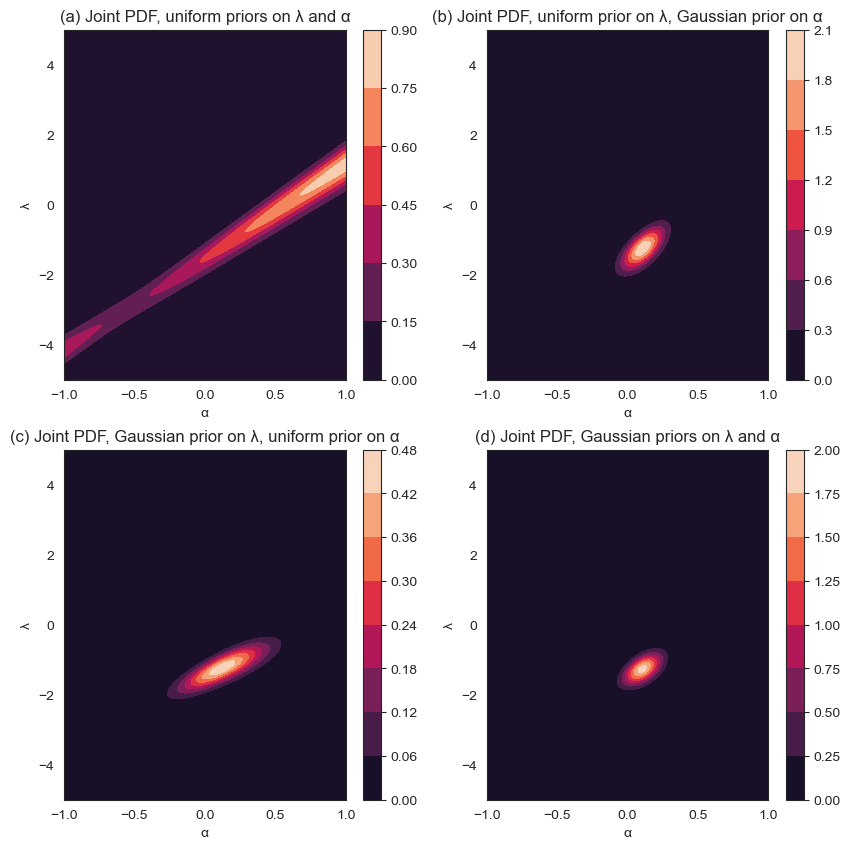

In [30]:
#META JPDF
plt.figure(figsize=(10,10))
ax=plt.subplot(2,2,1)
plt.contourf(alphas,lams,JPDF_meta)
plt.colorbar()
plt.title("(a) Joint PDF, uniform priors on λ and α")
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,3)
plt.contourf(alphas,lams,JPDF_meta*justproc)
plt.title("(c) Joint PDF, Gaussian prior on λ, uniform prior on α")
plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,2)
plt.contourf(alphas,lams,justalpha*JPDF_meta)
plt.title("(b) Joint PDF, uniform prior on λ, Gaussian prior on α")
plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,4)
plt.contourf(alphas,lams,justalpha*JPDF_meta*justproc)
plt.title("(d) Joint PDF, Gaussian priors on λ and α")
plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

In [31]:
alpha_gaussian=normlam(np.sum(justalpha*JPDF_annan,axis=1))

alpha_0=normlam(LGM0)


In [75]:
alpha_gaussian_tierney=normlam(np.sum(justalpha*JPDF_tierney,axis=1))

LGM0_tierney=np.array([LGM_likelihood(x,0,tempfrom="tierney") for x in lams])
alpha_0_tierney=normlam(LGM0_tierney)


In [133]:
max(set(Ssamps), key=Ssamps.tolist().count)

1.7616291477579864

In [138]:
def get_95_cl(posterior):
    lamsamps=np.random.choice(lams,10000,p=posterior/np.sum(posterior))
    print("λ (5-95% CL):", (np.round(np.percentile(lamsamps,5),2),np.round(np.percentile(lamsamps,95),2)))
    print("λ most likely",lams[np.argmax(posterior)])

    F2samps=np.random.normal(4,0.3,10000)
    Ssamps=-F2samps/lamsamps
    print("S (5-95% CL):", (np.round(np.percentile(Ssamps,5),2),np.round(np.percentile(Ssamps,95),2)))
    

In [141]:
get_95_cl(LGM0_meta)

λ (5-95% CL): (-2.09, -1.08)
λ most likely -1.5465465465465464
S (5-95% CL): (1.87, 3.75)


In [90]:
La0=normlam(lam_hist)*normlam(alpha_gaussian_meta)
lamsamps=np.random.choice(lams,1000,p=La0/np.sum(La0))
print(np.percentile(lamsamps,5))
print(np.percentile(lamsamps,95))

-1.8673673673673676
-0.7357357357357355


In [100]:
print(np.trapz(L0dL,x=lams))
print(np.trapz(La0,x=lams))

0.33262547408690823
0.4731273469821169


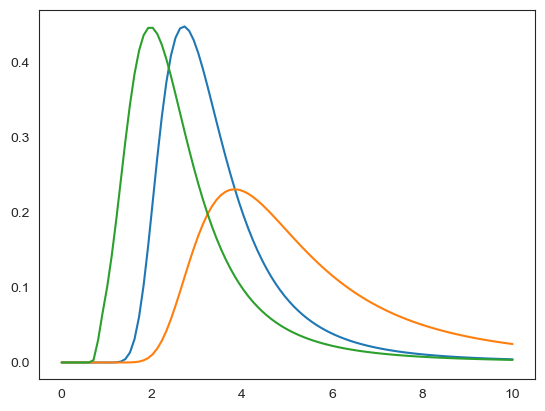

In [82]:
plt.plot(Ses,lam_to_S(alpha_gaussian_meta))
plt.plot(Ses,lam_to_S(alpha_gaussian_tierney))
plt.plot(Ses,lam_to_S(alpha_gaussian))

In [33]:
alpha_uniform = normlam(np.sum(JPDF_annan,axis=1))


In S20, we used a Gaussian prior for the state dependence.  This gives a different pdf than the marginal pdf we get by integrating over $\lambda$.

If you literally have no physical idea what the state dependence might be, net positive feebacks and strong state dependence best fit the data.  This is unphysical.

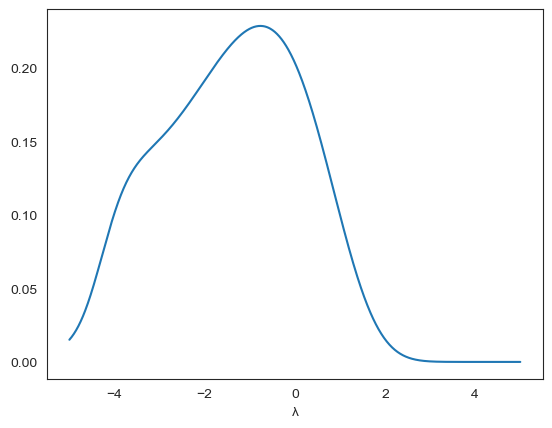

In [34]:
plt.figure()
JPDF_uniformalphanoproc=np.sum(JPDF_annan,axis=1)/np.trapz(np.sum(JPDF_annan,axis=1),x=lams)

plt.plot(lams,JPDF_uniformalphanoproc)
tmp=plt.xlabel("λ")

This expresses the (very obvious) fact that if you want the LGM to teach you anything, you need to have some sort of constraint on the state dependence $\alpha$.  If your prior treats every value of $\alpha$ as equally likely, the constraint from the LGM will be identical to that from the process evidence.  If, however, you know something (or believe you know something) about what, physically, the state dependence might be, then this allows the LGM evidence to place new additional constraints on the feedbacks.

Incorporating uncertainty in the state dependence broadens the range of possible $\lambda$ obtained from the LGM

# History
## Observations
Using Bellouin aerosol forcing as calculated by Piers and Mark for (Sherwood et al, 2020).

In [35]:
def bellouin_ringberg_stats_fix_200311_ERFaer(nsamples):
#From WCRP code downloaded 3/10
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import math

    # Distribution type
    # u - uniform, but arguments are 16th and 84th percentile
    #       assumes uniform outside these values (no very large values)
    # v - uniform, next two arguments are upper and lower bounds
    # c - constant value
    # n - normal distribution with bounds as 2 sigma width around an average mean

    d = {}
    d['rsdt'] =          ['c', -340]

    # Aerosol variables
    d['dtau'] =          ['u', 0.02,   0.04]
    d['tau'] =           ['u', 0.13,   0.17]

    # RFari terms
    d['S_tau'] =         ['u', -20,   -27]
    d['RFari_cloudy'] =  ['u', -0.1, 0.1 ]

    # RAari
    d['dR_dRatm'] =      ['u', -0.1, -0.3]
    d['dRatm_dtau'] =    ['u', 17,     35]

    # Cloud fractions
    d['c_tau'] =         ['u', 0.59,  0.71]
    d['c_N'] =           ['u', 0.19,  0.29]
    d['c_L'] =           ['u', 0.21, 0.29 ]
    d['c_C'] =           ['u', 0.59, 1.07 ]         

    # Nd sensitivity to aerosol, and adjustment terms
    d['beta_N_tau'] =   ['u', 0.3,    0.8]
    d['beta_L_N'] =     ['u', -0.36,  -0.011] 
    d['beta_C_N'] =       ['u', 0,      0.1]

    # Cloud albedo terms
    d['S_N'] =           ['u', -26,    -27]
    d['S_L'] =           ['u', -54,    -56]
    d['S_C'] =           ['u', -91,   -153]


    ############################################
    # Create the distributions and store in ds #
    ############################################

    ds = {}
    for name in d.keys():
      if d[name][0] == 'c':
          ds[name] = d[name][1]
      elif d[name][0] == 'u':
          diff = 16*(d[name][2]-d[name][1])/(84-16)
          ds[name] = np.random.uniform(d[name][1]-diff, d[name][2]+diff, nsamples)
      elif d[name][0] == 'v':
          ds[name] = np.random.uniform(d[name][1], d[name][2], nsamples)
      elif d[name][0] == 'n':
          cent = (d[name][2]+d[name][1])/2
          spread = (d[name][2]-d[name][1])/2
          ds[name] = np.random.uniform(cent, spread, nsamples)

    ############################
    # The Ringberg Equation!!! #
    ############################
    rfari = ds['dtau']*ds['S_tau']*(1-ds['c_tau'])+ds['RFari_cloudy']
    rfari_adj = ds['dtau']*ds['dR_dRatm']*ds['dRatm_dtau']

    ds['dlntau'] = ds['dtau']/ds['tau']
    deltan = ds['dlntau']*ds['beta_N_tau']

    rfaci = ds['dlntau']*ds['beta_N_tau']*ds['S_N']*ds['c_N']
    erfaci_L = ds['dlntau']*ds['beta_N_tau']*ds['beta_L_N']*ds['S_L']*ds['c_L']
    erfaci_C = ds['dlntau']*ds['beta_N_tau']*ds['beta_C_N']*ds['S_C']*ds['c_C']

    ERFaer=rfari+rfari_adj+rfaci+erfaci_L+erfaci_C
    return ERFaer

def read_hist_forc(hist_forcing_version='Bellouin_2020_eqn_8',\
                   alternative_pi_period=False,
                  period_1850_2005_2015=False,\
                  period_1750_2018=False):
    inpath = "WCRP_ECS_assessment_code_200714/"
    #start by making the forcing according to Piers' code and commentary

    #note the only edit I made to his files is to make the col names automatically readable for the 2nd one (ie removing spaces)

    # Piers Forster's code retained in comments marked PF 
    # James Annan's code retained in comments marked JDA



    # Read in data

    from io import StringIO   # StringIO behaves like a file object
    #from google.colab import drive
    #drive.mount('/content/gdrive')

    # **** Read in historical forcing upper, mid and lower ranges ****

    if hist_forcing_version == 'Bellouin_2020_eqn_8':
        hist_forcing_ranges='WCRP_forcing_ranges_200311.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_Bellouinaerosol2.csv'

    if hist_forcing_version == 'Bellouin_2020_constrained':
        hist_forcing_ranges='WCRP_forcing_ranges_Bellouinaerosol_constrained_200321.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_Bellouinaerosol2.csv'

    if hist_forcing_version == 'AR5_extended':
        hist_forcing_ranges='IPCCAR5_forcing_ranges_200320.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_AR5aerosol_200320.csv'

    best_upper_lower = pd.read_csv(inpath+hist_forcing_ranges,nrows=3)

    best=best_upper_lower.iloc[0]
    lower=best_upper_lower.iloc[1]
    upper=best_upper_lower.iloc[2]

    # PF ; assumes 90% are 1.65 sigma
    # PF sdlower=(best-lower)/1.65
    # PF sdupper=(upper-best)/1.65

    # MJW calulate standard deviations which would give lower and upper values as 5-95% ranges
    # assumes 90% are 1.64 sigma
    sdlower=(best-lower)/1.64
    sdupper=(upper-best)/1.64

    

    # **** Read in AR5 annual mean forcing data ****

    df=pd.read_csv(inpath+hist_monthly_forcings,delimiter=',',skiprows=19)

    #print (forc_table["Year/month"]
    df = df.set_index(['Year/month']) 

    df_baseline=df.loc[1861:1880]
    #df_recent=df.loc[2002:2017]
    df_recent=df.loc[2006:2018] # updated 16/3/20

    if alternative_pi_period:
        df_baseline=df.loc[1850:1900]

    if period_1850_2005_2015:
        df_baseline=df.loc[[1850,1850]]
        df_recent=df.loc[2005:2015]

    if period_1750_2018:
        df_baseline=df.loc[[1750,1750]]
        df_recent=df.loc[[2018,2018]]

   # print (df_baseline)
   # print (df_recent)

    # JDA: CO2 forcing is based on F2x so I will back-calculate the doubling fraction from this
    #
    # JDA: now generate a sample of all the other forcings

    uncs_neg = ( best - lower ) / (1.64 * best )
    uncs_pos = ( upper - best ) / (1.64 * best )

    return (df_recent,df_baseline,uncs_neg,uncs_pos)

def get_total_forcing(nsamp):
    #Aerosol forcing is different- median is -1.1, not -1.179
    df_recent,df_baseline,uncs_neg,uncs_pos=read_hist_forc()

   
    labels = ['Other WMGHG','O3 (T)','O3(S)','ERF LUC','Vapour','BC snow','contrails','Solar','Volcanic',"total aerosol ERF"] 
    f_other = np.zeros(nsamp)
    devs = np.random.normal(loc=0.0, scale=1.0, size=nsamp)
    for label in labels:
        baseline=df_baseline[label].to_numpy()
        baseline=np.mean(baseline)

        recent=df_recent[label].to_numpy()
        recent=np.mean(recent)

        if label != "total aerosol ERF":

            devscaled = (devs >= 0) * devs * uncs_pos[label] 
            devscaled = devscaled + (devs < 0) * devs * uncs_neg[label]
            f_component = (recent - baseline) * (1+devscaled)
            f_other=f_other+f_component
        else:
            #aerosols
            ERFaer = bellouin_ringberg_stats_fix_200311_ERFaer(nsamp)
            #devscaled=ERFaer/np.median(ERFaer)-1.0
            # rescale by the factor that reproduces Bellouin et al 2020 PDF between 1850 and 2005-2015
            peak_ERFaer=-0.87
            devscaled=ERFaer/peak_ERFaer-1.0
            #print(recent-baseline)
            total_aerosol_forcing=(recent - baseline) * (1+devscaled)
            #print("Aerosol 5-95 range",np.percentile(total_aerosol_forcing,5),np.percentile(total_aerosol_forcing,95))
            #print("aserosol median",np.median(total_aerosol_forcing))


    #CO2
    label='CO2'
    baseline=df_baseline[label].to_numpy()
    baseline=np.mean(baseline)

    recent=df_recent[label].to_numpy()
    recent=np.mean(recent)

    CO2_hist_mean = (recent - baseline)

    F2x=4.
    F2x_error=np.random.normal(F2x,0.49/1.64,size=nsamp)
    CO2_hist=CO2_hist_mean*F2x/np.mean(F2x)

    tot_f=f_other+total_aerosol_forcing+CO2_hist
    return tot_f


In [36]:
Fwebb=pd.read_csv("f_bin_centres.csv",header=None)
bincentres=Fwebb[0].values
likwebbF=pd.read_csv("total_hist_erf_prior.csv",header=None)
forcing_prior_webb=likwebbF[0].values

In [37]:
from scipy.interpolate import interp1d
webbinterp = interp1d(bincentres, forcing_prior_webb, kind='cubic',fill_value=0,bounds_error=False)



## Other observations


Temperature and imbalance estimates taken from Table 5 of (Sherwood et al 2020); 5-95% confidence levels converted into $\sigma$ using normal distribution

$\Delta T \sim \mathcal{N}(1.03,0.085)$

$\Delta N \sim \mathcal{N}(0.6,0.18)$

In [38]:
nsamp=10000
scale90=stats.norm.interval(.9)[1]

dF_obs=get_total_forcing(nsamp)
dT_obs=np.random.normal(1.03,(.17-.03)/scale90,nsamp)
dN_obs=np.random.normal(.6,0.3/scale90,nsamp)

x=dN_obs-dT_obs

F2x=4.
F2x_error=np.random.normal(F2x,0.49/1.64,size=nsamp)
    

Calculate a kernel density estimate from these samples (do this numerically since we don't have a functional form for $\Delta F$)

In [39]:
test_values=np.zeros((3,nsamp))
test_values[0]=dT_obs
test_values[1]=dF_obs
test_values[2]=dN_obs


test_kde=stats.gaussian_kde(test_values)

The simplest energy balance model is 

$\Delta N = \lambda \Delta T + \Delta F$

This is deterministic: if we knew the "true" values of the imbalance, temperature change, and forcing, we'd know the feedback parameter exactly.  That is: there is no randomness in $\lambda$ or uncertainty in this model: the uncertainty in $\lambda$ is completely due to the uncertainty in the observations. 

(Aside: if we consider shorter-term observations, we have to consider internal variability.  In that case, the model is $$\Delta N = \lambda \Delta T + \Delta F+V$$ and we have to consider a further hierarchical step 
$$\lambda_{obs} \sim \mathcal{N}(\lambda_{true},\sigma_V^2)$$ where we assume the observed values of $\lambda$ are normally distributed about the "true" (latent) feedback parameter and $\sigma_V^2$ represents the scatter due to internal variability of the climate system.  But let's not get ahead of ourselves.)

This model defines a plane in $(\Delta T, \Delta N, \Delta F)$ space.

Intuitively, the likelihood of the observed evidence given a value of $\lambda$ depends on the intersection of the plane defined by $\lambda$ and the joint PDF of the observations.  A plane that cuts through a large section of the PDF corresponds to a high likelihood of the evidence given that particular $\lambda$, while a plane that just grazes the side corresponds to a low likelihood.  This is a 3D generalization of the method used in Sherwood et al for the historical section.

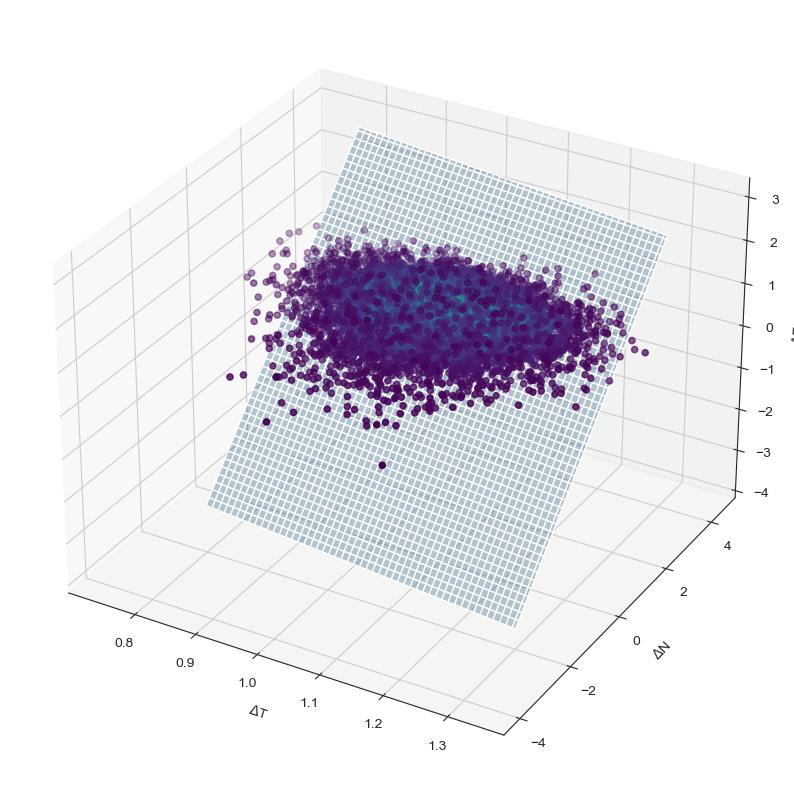

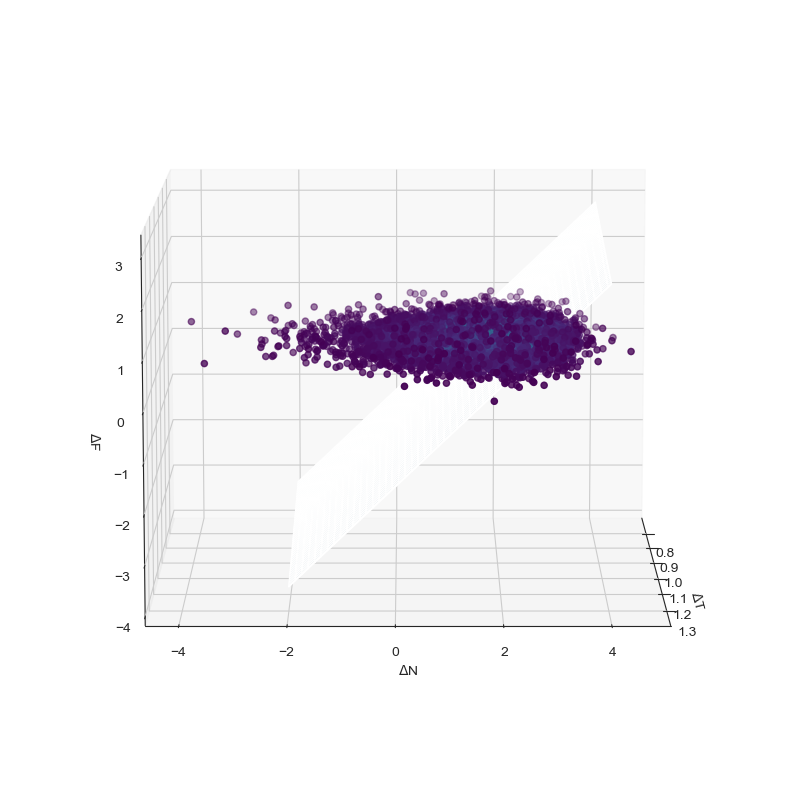

In [40]:
sns.set_style("white")

def plot_plane_lam(lam,ax):
    Ts = np.linspace(.8,1.3,int(nsamp/100))
    Fs = np.linspace(-2,4.0,int(nsamp/100))
    xx,yy=np.meshgrid(Ts,Fs)
    #zz = -1/lam*(xx-yy)
    zz = lam*xx+yy
    ax.plot_surface(xx,yy,zz,alpha=.3,label="lam = "+str(lam))

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,20))
plt.set_cmap(cm.viridis)

ax.scatter(test_values[0], test_values[1], test_values[2], c=test_kde(test_values))
tmp=ax.set_xlabel(r'$\Delta$T')
tmp=ax.set_ylabel(r'$\Delta$N')
tmp=ax.set_zlabel(r'$\Delta$F')

#plot_plane_lam(0,ax=ax)
plot_plane_lam(mulam,ax=ax)
plt.show(())
elev = 10
azim=0
roll=0
ax.view_init(elev, azim, roll)
# plot_plane_lam(-.5,ax=ax)
# ax.set_zlim(-1,3)
# plt.show()

Define the likelihood as the surface integral of the joint PDF of observations over the plane defined by $\lambda$:

$$\int \int PDF(\Delta T, \Delta F, \Delta N) dS = \int \int PDF( \vec{r}(u,v) )|| r_u \times r_v|| dA$$
where 
$$\vec{r} =u \hat{i} + v \hat{j} + (\lambda u+ v)\hat{k}$$
If the observations $\Delta T, \Delta F, \Delta N$ are all independent and normally distributed, we can write this integral in terms of Gaussians and get a nice analytic functional form.  This is moot because $\Delta F$ is not normally distributed.  So let's do it numerically:

In [41]:
#Functional form of the likelihood P(evidence | λ)
#This takes longer than I'd like, but maybe we can fit a spline to a bunch of samples to make it go faster
def likelihood_density_lambda(λ,Δλ,tmin=-10,tmax=10,qmin=-10,qmax=10):
    ru=np.array([1,0,λ-Δλ])
    rv=np.array([0,1,1])
    jacobian=np.linalg.norm(np.cross(ru,rv))
    func=lambda u,v: test_kde((u,v,(λ-Δλ)*u+v))*jacobian
    return integrate.dblquad(func,tmin,tmax,lambda u: qmin, lambda u: qmax)[0]

In [42]:
dF_obs=get_total_forcing(nsamp)

forcing_prob=stats.gaussian_kde(dF_obs)
def PT_hist(T,tempfrom="tierney"):
      
    muT= 1.03
    sigT=(.17-.03)/scale90

     
    return np.exp(-0.5*(T-muT)**2/sigT**2)*1/(np.sqrt(2*np.pi)*sigT)
def PN_hist(N):
    
    muN=0.6
    sigN=0.3/scale90

   
    return np.exp(-0.5*(N-muN)**2/sigN**2)*1/(np.sqrt(2*np.pi)*sigN)

def PF_hist(F):
    return forcing_prob(F)


def quicker_kde(T,F,N):
    return PT_hist(T)*PF_hist(F)*PN_hist(N)
def quickest_kde(T,F,N):
    return PT_hist(T)*webbinterp(F)*PN_hist(N)


def likelihood_density_lambda_quick(λ,Δλ,tmin=-10,tmax=10,qmin=-10,qmax=10):
    ru=np.array([1,0,λ-Δλ])
    rv=np.array([0,1,1])
    jacobian=np.linalg.norm(np.cross(ru,rv))
    func=lambda u,v: quicker_kde(u,v,(λ-Δλ)*u+v)*jacobian
    return integrate.dblquad(func,tmin,tmax,lambda u: qmin, lambda u: qmax)[0]


def likelihood_density_lambda_quickest(λ,Δλ,tmin=-10,tmax=10,qmin=-10,qmax=10):
    ru=np.array([1,0,λ-Δλ])
    rv=np.array([0,1,1])
    jacobian=np.linalg.norm(np.cross(ru,rv))
    func=lambda u,v: quickest_kde(u,v,(λ-Δλ)*u+v)*jacobian
    return integrate.dblquad(func,tmin,tmax,lambda u: qmin, lambda u: qmax)[0]

In [43]:

pickle_historical=False
if pickle_historical:
    today=datetime.date.today().strftime("%m%d%Y")
    lam_hist=[]
    #lams=np.linspace(-5,5,1000)
    #pattern = np.linspace(-2,2,500)
    for i in range(len(lams)):
        print(i)
        lam=lams[i]
      
        lam_hist+=[likelihood_density_lambda_quickest(lam,0,tmin=-np.inf,tmax=np.inf,qmin=-np.inf,qmax=np.inf)]
    import pickle
    with open("PICKLED/lam_hist_"+today+".dat","wb") as picklefile:
        pickle.dump(np.array(lam_hist),picklefile)
else:
    with open("PICKLED/lam_hist_06142022.dat","rb") as picklefile:
        lam_hist=pickle.load(picklefile)


Text(0.5, 0, 'λ')

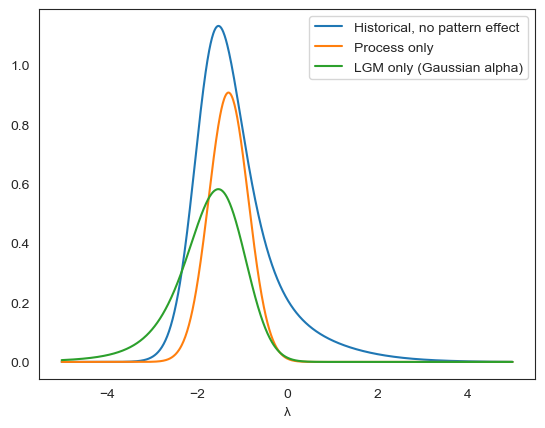

In [44]:
plt.figure()
plt.plot(lams,lam_hist,label="Historical, no pattern effect")
plt.plot(lams,proc,label="Process only")
plt.plot(lams,alpha_gaussian,label="LGM only (Gaussian alpha)")
plt.legend()
plt.xlabel("λ")

In [45]:
#retrofit with pattern effect
pattern = np.linspace(-2,2,500)
patternshape=len(pattern)
histJPDF=np.zeros((lamshape,patternshape))
for i in range(lamshape):
    for j in range(patternshape):
        lamtest=lams[i]
        patttest=pattern[j]
        tot_lam=lamtest-patttest
        if np.abs(tot_lam)>=5.:
            lik=0.
        else:
            lik=lam_hist[np.argmin(np.abs(lams-tot_lam))  ]
        histJPDF[i,j]=lik

## Prior on $\Delta \lambda$
Assume, as in S20, a Gaussian prior on the pattern effect

In [46]:
patternmean=0.5
patternsigma=0.5/scale90

patternprior=np.exp(-1/2.*(pattern-patternmean)**2/patternsigma**2)*1/(np.sqrt(2*np.pi)*patternsigma)



patternprior2=np.exp(-1/2.*(pattern-0.2)**2/patternsigma**2)*1/(np.sqrt(2*np.pi)*patternsigma)

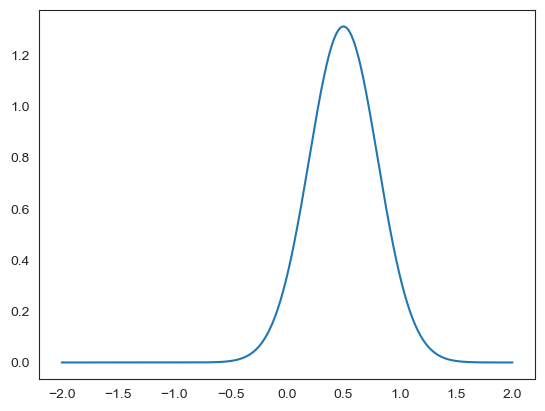

In [47]:
plt.figure()
plt.plot(pattern,patternprior)

The effect of this prior is to shift the PDF for $\lambda$ (marginalized over $\Delta \lambda$ ) to less negative feedbacks -> higher climate sensitivities

In [48]:
#Model comparision

Text(0, 0.5, 'Likelihood')

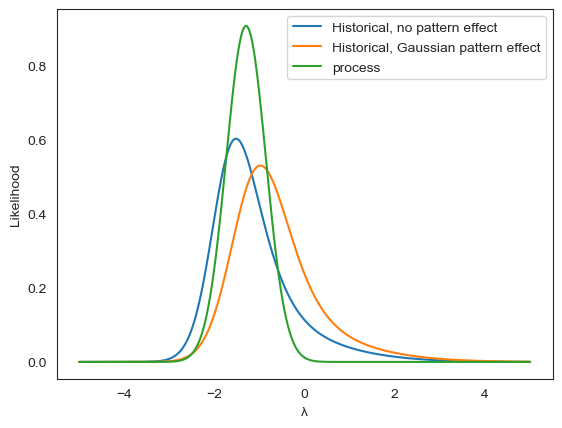

In [49]:
plt.figure()

plt.plot(lams,lam_hist/np.trapz(lam_hist,x=lams),label="Historical, no pattern effect")
historical_patterneffect_gaussian_prior=np.dot(histJPDF,patternprior)/np.trapz(np.dot(histJPDF,patternprior),x=lams)
historical_2_patterneffect_gaussian_prior=np.dot(histJPDF,patternprior2)/np.trapz(np.dot(histJPDF,patternprior2),x=lams)
plt.plot(lams,historical_patterneffect_gaussian_prior,label="Historical, Gaussian pattern effect")
plt.plot(lams,proc, label="process")
plt.legend()
plt.xlabel("λ")
plt.ylabel("Likelihood")

In [50]:
def ana_historical(λ,Δλ):
    μ_x = 1.03
    σ_x = 0.2/scale90

    μ_y = 2.2
    σ_y = 0.71/scale90

    μ_z = 0.59
    σ_z = 0.35/scale90
    
    A11=1/σ_x**2 + (λ-Δλ)**2/σ_z**2
    A12 = (λ-Δλ)/σ_z**2
    A21 = (λ-Δλ)/σ_z**2
    A22 = 1/σ_y**2 + 1/σ_z**2
    A=np.array([[A11,A12],[A21,A22]])
    J1 = μ_x/σ_x**2 + (λ-Δλ)*μ_z/σ_z**2
    J2 =  μ_y/σ_y**2 + μ_z/σ_z**2
    J=np.array([J1,J2])

    C=μ_x**2/σ_x**2+μ_y**2/σ_y**2+μ_z**2/σ_z**2

    L=np.sqrt((λ-Δλ)**2+2)*2*np.pi/np.sqrt(np.linalg.det(A))*np.exp(-0.5*C)*np.exp(0.5*np.dot(np.dot(np.transpose(J),np.linalg.inv(A)),J))
    return L



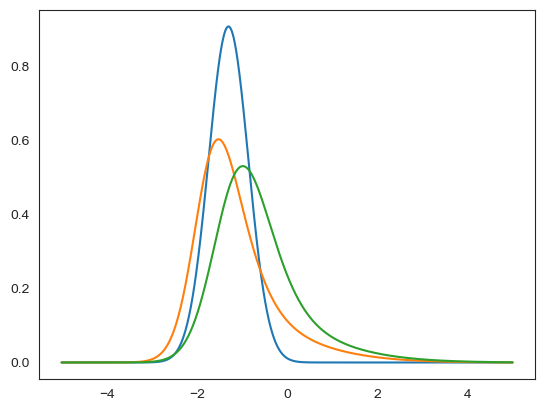

In [51]:
plt.plot(lams,normlam(proc))
plt.plot(lams,normlam(lam_hist))
plt.plot(lams,normlam(historical_patterneffect_gaussian_prior))

In [52]:
nopatt=np.trapz(normlam(lam_hist)*normlam(alpha_0_tierney),x=lams)
patt=np.trapz(normlam(historical_patterneffect_gaussian_prior)*normlam(alpha_0_tierney),x=lams)
patt/nopatt

1.0131842262911606

In [53]:
pattern = np.linspace(-2,2,500)
patternshape=len(pattern)
histJPDF_ana=np.zeros((lamshape,patternshape))
for i in range(lamshape):
    for j in range(patternshape):
        lamtest=lams[i]
        patttest=pattern[j]
       
        histJPDF_ana[i,j]=ana_historical(lamtest,patttest)

# Posterior predictive distribution
$$P(Y_{pred} | Y) = \int_{\Theta} P(Y_{pred} | \Theta) p(\Theta | Y) d\Theta$$
For the historical, $Y_{pred} = (\Delta T, \Delta F, \Delta N)$
The first term in the integral is the likelihood of observing $Y_{pred}$ given the posterior $\Theta$

Using the LGM evidence from S20, we find greater overlap in the posteriors for lambda when using the Gaussian prior on alpha: a positive state dependence makes the results agree more with the historical evidence.

Marginalizing over alpha : assessing models against LGM evidence only

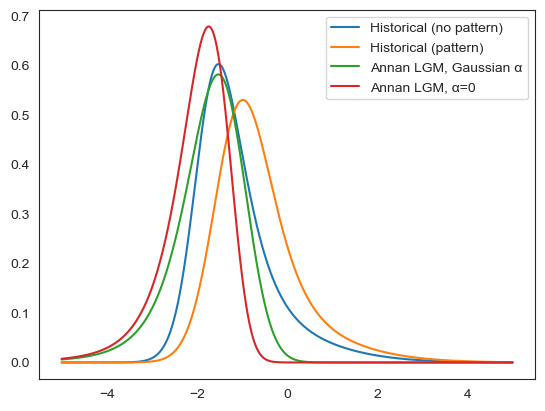

In [54]:
plt.figure()
plt.plot(lams,normlam(lam_hist),label="Historical (no pattern)")
plt.plot(lams,normlam(historical_patterneffect_gaussian_prior),label="Historical (pattern)")
plt.plot(lams,alpha_gaussian, label="Annan LGM, Gaussian α")
plt.plot(lams,alpha_0,label="Annan LGM, α=0")
plt.legend()
#plt.plot(lams,alpha_gaussian)

# Model evaluation
$𝑃(𝑀_{0,\Delta\lambda})=1$

In [115]:
alpha_gaussian_meta=normlam(np.sum(justalpha*JPDF_meta,axis=1))

LGM0_meta=np.array([LGM_likelihood(x,0,tempfrom="meta") for x in lams])
alpha_0_meta=normlam(LGM0_meta)


L0dL=normlam(historical_patterneffect_gaussian_prior)*normlam(alpha_0_meta)
lamsamps=np.random.choice(lams,10000,p=L0dL/np.sum(L0dL))
print(np.percentile(lamsamps,5))
print(np.percentile(lamsamps,95))

F2samps=np.random.normal(4,0.3,10000)
Ssamps=-F2samps/lamsamps
print(np.percentile(Ssamps,5))
print(np.percentile(Ssamps,95))

-1.886886886886887
-1.016016016016016
2.0588822735722627
4.0068875208851376


$P(M_{\alpha,0})=1$

In [114]:
La0=normlam(lam_hist)*normlam(alpha_gaussian_meta)
lamsamps=np.random.choice(lams,10000,p=La0/np.sum(La0))
print(np.percentile(lamsamps,5))
print(np.percentile(lamsamps,95))

F2samps=np.random.normal(4,0.3,10000)
Ssamps=-F2samps/lamsamps
print(np.percentile(Ssamps,5))
print(np.percentile(Ssamps,95))

-1.876876876876877
-0.7457457457457455
2.0833813472164624
5.382352670925708


In [111]:
w0n=np.trapz(L0dL,lams)
wan=np.trapz(La0,lams)
denom=w0n+wan
w0=w0n/denom
wa=wan/denom
#assuming lam ~ U(-10,10)
weighted_posterior=w0*L0dL+wa*La0
lamsamps=np.random.choice(lams,10000,p=weighted_posterior/np.sum(weighted_posterior))
print(np.percentile(lamsamps,5))
print(np.percentile(lamsamps,95))

F2samps=np.random.normal(4,0.3,10000)
Ssamps=-F2samps/lamsamps
print(np.percentile(Ssamps,5))
print(np.percentile(Ssamps,95))

-1.876876876876877
-0.8058058058058055
2.0775854431205616
5.001637097926872


In [55]:
print("M0 Annan historical", np.trapz(lam_hist*alpha_0,x=lams))
print("M0 Tierney historical", np.trapz(lam_hist*alpha_0_tierney,x=lams))

M0 Annan historical 0.6665832315691106
M0 Tierney historical 0.9117309485387655


In [56]:
print("Mα Annan", np.trapz(lam_hist*alpha_gaussian,x=lams))
print("Mα Tierney", np.trapz(lam_hist*alpha_gaussian_tierney,x=lams))

Mα Annan 0.698745539297798
Mα Tierney 0.641920620790213


In [57]:
print("M0 Annan process", np.trapz(proc*alpha_0,x=lams))
print("M0 Tierney process", np.trapz(proc*alpha_0_tierney,x=lams))

M0 Annan process 0.3932672571960527
M0 Tierney process 0.790804526188033


In [58]:
print("Mα Annan process", np.trapz(proc*alpha_gaussian,x=lams))
print("Mα Tierney process", np.trapz(proc*alpha_gaussian_tierney,x=lams))

Mα Annan process 0.45100515340630665
Mα Tierney process 0.4736422202021522


In [59]:
print("M0 historical process", np.trapz(proc*normlam(lam_hist),x=lams))
print("Mpatt historical process", np.trapz(proc*historical_patterneffect_gaussian_prior,x=lams))

M0 historical process 0.46822599955346855
Mpatt historical process 0.39791033557412814


In [351]:
print("M00 Annan ", np.trapz(normlam(lam_hist)*alpha_0,x=lams))
print("Mα0 Annan ", np.trapz(normlam(lam_hist)*alpha_gaussian,x=lams))
print("M0Δλ Annan ", np.trapz(historical_patterneffect_gaussian_prior*alpha_0,x=lams))
print("MαΔλ Annan ", np.trapz(historical_patterneffect_gaussian_prior*alpha_gaussian,x=lams))

M00 Annan  0.35498307644856125
Mα0 Annan  0.3613404672393681
M0Δλ Annan  0.20505329558553995
MαΔλ Annan  0.253690904457585


In [61]:
annan_nostate=np.trapz(historical_patterneffect_gaussian_prior*alpha_0,x=lams)
annan_state=np.trapz(historical_patterneffect_gaussian_prior*alpha_gaussian,x=lams)
annan_state/annan_nostate

1.3290428710369588

In [62]:
print("M00 Tierney ", np.trapz(normlam(lam_hist)*alpha_0_tierney,x=lams))
print("Mα0 Tierney ", np.trapz(normlam(lam_hist)*alpha_gaussian_tierney,x=lams))
print("M0Δλ Tierney ", np.trapz(historical_patterneffect_gaussian_prior*alpha_0_tierney,x=lams))
print("MαΔλ Tierney ", np.trapz(historical_patterneffect_gaussian_prior*alpha_gaussian_tierney,x=lams))

M00 Tierney  0.4855343514174497
Mα0 Tierney  0.34184921854016753
M0Δλ Tierney  0.4919357461786692
MαΔλ Tierney  0.457425128382318


In [63]:
tierney_nostate=np.trapz(historical_patterneffect_gaussian_prior*alpha_0_tierney,x=lams)
tierney_state=np.trapz(historical_patterneffect_gaussian_prior*alpha_gaussian_tierney,x=lams)
tierney_state/tierney_nostate

0.9298473061483582

Text(0.5, 0, 'λ')

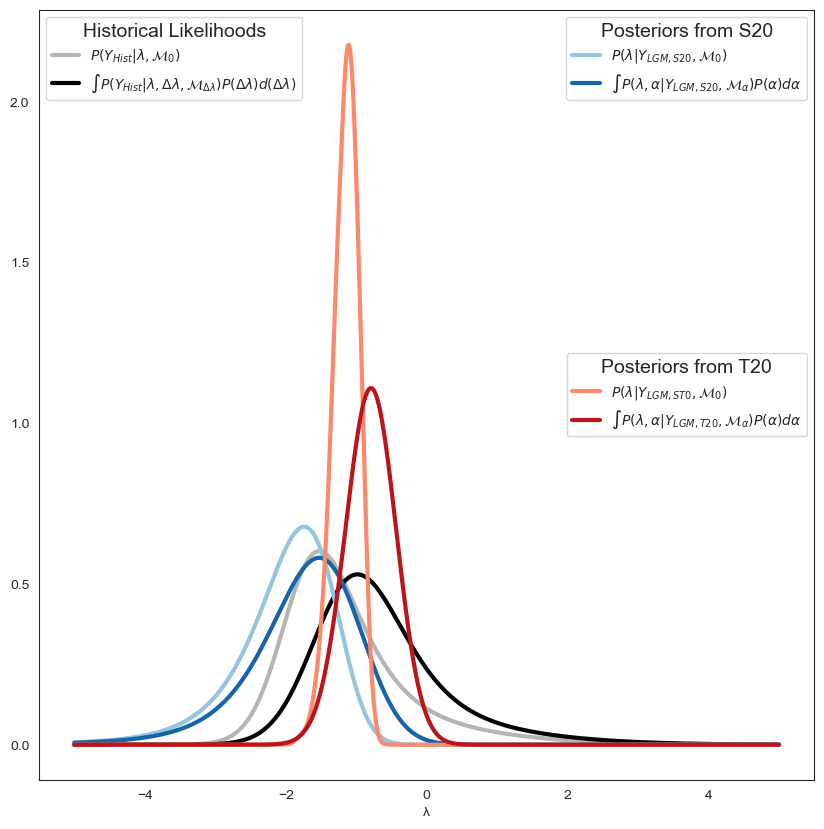

In [64]:
plt.figure(figsize=(10,10))
lw=3
plt.plot(lams,normlam(lam_hist),\
         label=r"Historical likelihood: $P(Y_{Hist}| \Theta, \mathcal{M}_{0})$",\
         c=cm.Greys(.4),lw=lw)
plt.plot(lams,historical_patterneffect_gaussian_prior,\
         label=r"$P(Y_{Hist}| \Theta, \mathcal{M}_{\Delta \lambda})$",\
         c=cm.Greys(.99),lw=lw)

plt.plot(lams,normlam(alpha_0),\
         label=r"$P(\lambda  | Y_{LGM, S20},\mathcal{M}_{0})$",\
         c=cm.Blues(.4),lw=lw)
plt.plot(lams,normlam(alpha_gaussian),\
         label=r"$\int P(\lambda ,\alpha | Y_{LGM, S20},\mathcal{M}_{\alpha}) P(\alpha) d\alpha$",\
         c=cm.Blues(.8),lw=lw)

plt.plot(lams,normlam(alpha_0_tierney),\
         label=r"$P(\lambda  | Y_{LGM, T20},\mathcal{M}_{0})$",\
         c=cm.Reds(.4),lw=lw)
plt.plot(lams,normlam(alpha_gaussian_tierney),\
         label=r"$\int P(\lambda ,\alpha | Y_{LGM, T20},\mathcal{M}_{\alpha}) P(\alpha) d\alpha$",\
         c=cm.Reds(.8),lw=lw)


lines=plt.gca().get_lines()

leg1=plt.legend([lines[i] for i in [0,1]],\
           [r"$P(Y_{Hist}| \lambda, \mathcal{M}_{0})$", \
            r"$\int P(Y_{Hist}| \lambda, \Delta \lambda , \mathcal{M}_{\Delta \lambda}) P(\Delta \lambda) d(\Delta\lambda)$"],\
           loc='upper left',title="Historical Likelihoods",title_fontsize=14)
leg2=plt.legend([lines[i] for i in [2,3]],\
           [r"$P(\lambda  | Y_{LGM, S20},\mathcal{M}_{0})$",\
            r"$\int P(\lambda ,\alpha | Y_{LGM, S20},\mathcal{M}_{\alpha}) P(\alpha) d\alpha$"],\
           loc='upper right',title="Posteriors from S20",title_fontsize=14)

leg3=plt.legend([lines[i] for i in [4,5]],\
           [r"$P(\lambda  | Y_{LGM, ST0},\mathcal{M}_{0})$",\
            r"$\int P(\lambda ,\alpha | Y_{LGM, T20},\mathcal{M}_{\alpha}) P(\alpha) d\alpha$"],\
           loc='center right',title="Posteriors from T20",title_fontsize=14)
plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)
plt.xlabel("λ")

#plt.savefig("FIGS/PPDs.png")

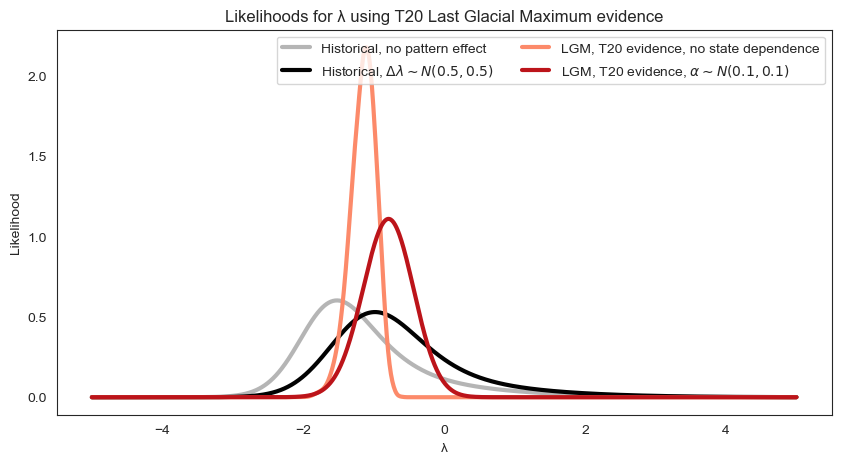

In [65]:
#plt.title("(b): Likelihoods using S20 Last Glacial Maximum evidence")

#plt.subplot(2,2,3)
plt.figure(figsize=(10,5))
lw=3
plt.plot(lams,normlam(lam_hist),\
         label=r"Historical, no pattern effect",\
         c=cm.Greys(.4),lw=lw)
plt.plot(lams,historical_patterneffect_gaussian_prior,\
         label=r"Historical, $\Delta \lambda \sim N(0.5,0.5)$",\
         c=cm.Greys(.99),lw=lw)



plt.plot(lams,normlam(alpha_0_tierney),\
         label="LGM, T20 evidence, no state dependence",\
         c=cm.Reds(.4),lw=lw)
plt.plot(lams,normlam(alpha_gaussian_tierney),\
         label=r"LGM, T20 evidence, $\alpha \sim N(0.1,0.1)$",\
         c=cm.Reds(.8),lw=lw)


plt.xlabel("λ")
plt.ylabel("Likelihood")
plt.legend(ncol=2)
plt.title("Likelihoods for λ using T20 Last Glacial Maximum evidence")

plt.savefig("FIGS/Tierney_two_towers.png")

In [66]:
M0Δλ_tierney=np.trapz(historical_patterneffect_gaussian_prior*normlam(alpha_0_tierney),x=lams)
Mα0_tierney=np.trapz(normlam(lam_hist)*normlam(alpha_gaussian_tierney),x=lams)
MαΔλ_tierney=np.trapz(historical_patterneffect_gaussian_prior*normlam(alpha_gaussian_tierney),x=lams)
M00_tierney=np.trapz(normlam(lam_hist)*normlam(alpha_0_tierney),x=lams)
print(Mα0_tierney/M0Δλ_tierney)
print(M0Δλ_tierney/M00_tierney)

0.6949062376451277
1.0131842262911606


In [67]:
M0Δλ_meta=np.trapz(historical_patterneffect_gaussian_prior*normlam(alpha_0_meta),x=lams)
Mα0_meta=np.trapz(normlam(lam_hist)*normlam(alpha_gaussian_meta),x=lams)
MαΔλ_meta=np.trapz(historical_patterneffect_gaussian_prior*normlam(alpha_gaussian_meta),x=lams)
M00_meta=np.trapz(normlam(lam_hist)*normlam(alpha_0_meta),x=lams)
print(Mα0_meta/M0Δλ_meta)
print(M0Δλ_meta/M00_meta)
print(M00_meta/Mα0_meta)
print(M00_meta/MαΔλ_meta)

NameError: name 'alpha_0_meta' is not defined

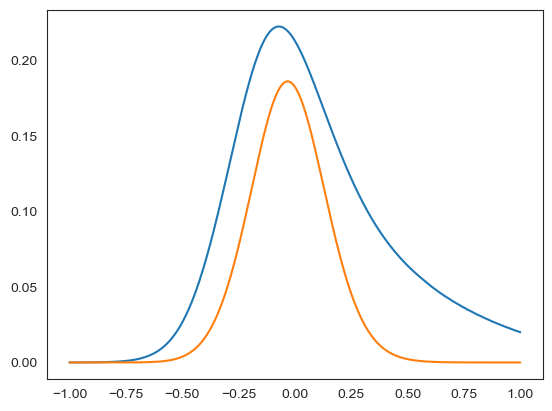

In [356]:
#Large-ish positive alpha is better at "explaining" the historical observations if you use Annan; 
tst_tierney_proc=[np.trapz(proc*JPDF_tierney[:,i],x=lams) for i in range(500)]
tst_tierney=[np.trapz(lam_hist*JPDF_tierney[:,i],x=lams) for i in range(500)]
tst_annan_proc=[np.trapz(proc*JPDF_annan[:,i],x=lams) for i in range(500)]
tst_annan=[np.trapz(lam_hist*JPDF_annan[:,i],x=lams) for i in range(500)]
plt.figure()
plt.plot(alphas,tst_tierney)
plt.plot(alphas,tst_tierney_proc)

Text(0.5, 0, 'Δλ')

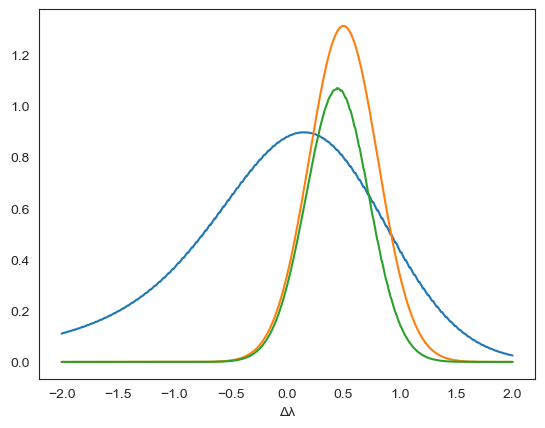

In [357]:
#and for process: most credible model is one with positive pattern effect.  But still EXTREMELY weakly constrained.≥ mnjhbv ghggfgghghfghhghnbhhnbhhhhb vv v  vvv  vb v v   v v v. b nbbb mmm,     
likelihood_proc_given_historical=[np.trapz(proc*histJPDF[:,i],x=lams) for i in range(500)]
likelihood_tierney_gaussian_given_historical=[np.trapz(alpha_gaussian_tierney*histJPDF[:,i],x=lams) for i in range(500)]
plt.figure()
plt.plot(pattern,likelihood_proc_given_historical)
plt.plot(pattern,patternprior)
plt.plot(pattern,likelihood_proc_given_historical*patternprior)
plt.xlabel("Δλ")

(-2.0, 2.0)

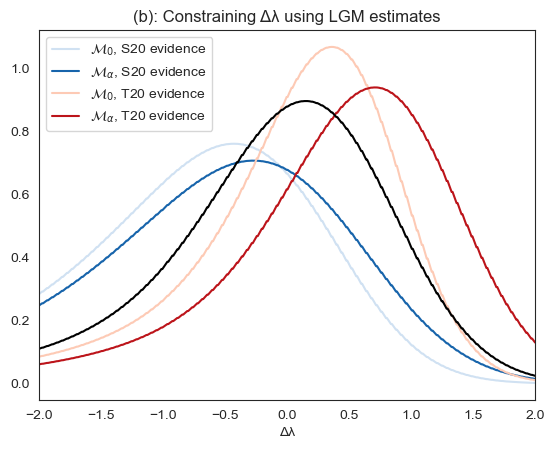

In [358]:
# invert this: how likely is LGM evidence given lambda posterior from historical?
#Given LGM data reported in S20, what is most likely model?  It's one with a negative (!!) pattern effect.  
#Because the S20 estimates of the LGM aren't very sensitive

likelihood_annan_0_given_historical=[np.trapz(alpha_0*histJPDF[:,i],x=lams) for i in range(500)]
likelihood_annan_gaussian_given_historical=[np.trapz(alpha_gaussian*histJPDF[:,i],x=lams) for i in range(500)]

likelihood_tierney_0_given_historical=[np.trapz(alpha_0_tierney*histJPDF[:,i],x=lams) for i in range(500)]
likelihood_tierney_gaussian_given_historical=[np.trapz(alpha_gaussian_tierney*histJPDF[:,i],x=lams) for i in range(500)]
plt.figure()
plt.plot(pattern,likelihood_annan_0_given_historical,label=r"$\mathcal{M}_0$, S20 evidence",c=cm.Blues(.2))
plt.plot(pattern,likelihood_annan_gaussian_given_historical,label=r"$\mathcal{M}_{\alpha}$, S20 evidence",c=cm.Blues(.8))
plt.plot(pattern,likelihood_tierney_0_given_historical,label=r"$\mathcal{M}_0$, T20 evidence",c=cm.Reds(.2))
plt.plot(pattern,likelihood_tierney_gaussian_given_historical,label=r"$\mathcal{M}_{\alpha}$, T20 evidence",c=cm.Reds(.8))
plt.plot(pattern,likelihood_proc_given_historical,c="k")
plt.xlabel("Δλ")
plt.title("(b): Constraining Δλ using LGM estimates")
plt.legend()
plt.xlim(-2,2)

In [359]:
alpha_gaussian_meta=normlam(np.sum(justalpha*JPDF_meta,axis=1))

alpha_gaussian_meta_old=normlam(np.sum(justalpha*JPDF_meta_old,axis=1))


NameError: name 'JPDF_meta_old' is not defined

In [120]:
LGM0_meta=np.array([LGM_likelihood(x,0,tempfrom="meta") for x in lams])
alpha_0_meta=normlam(LGM0_meta)
S_alpha_0_meta=lam_to_S(alpha_0_meta)

Text(0.5, 0, '$\\lambda$')

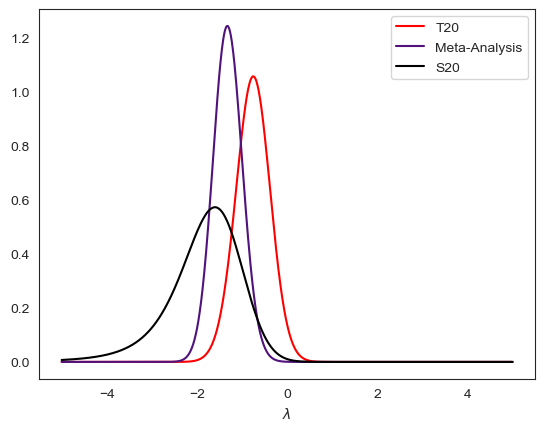

In [361]:
plt.figure()

plt.plot(lams,alpha_gaussian_tierney,label="T20",c="r")
plt.plot(lams,alpha_gaussian_meta,label="Meta-Analysis",c=cm.magma(.25))

plt.plot(lams,alpha_gaussian,label="S20",c="k")
plt.legend()
plt.xlabel(r"$\lambda$")

Text(0, 0.5, 'Likelihood')

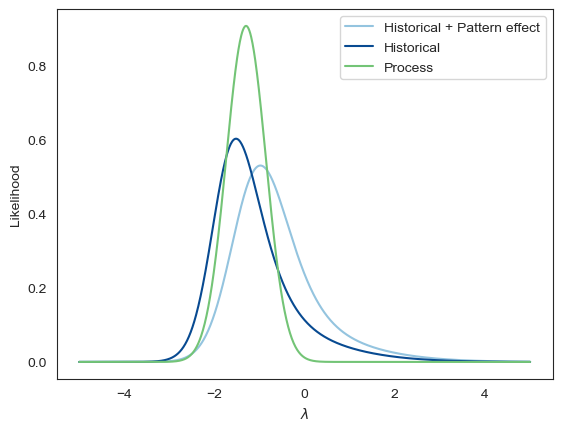

In [362]:
plt.plot(lams,historical_patterneffect_gaussian_prior,label="Historical + Pattern effect",c=cm.Blues(.4))
plt.plot(lams,normlam(lam_hist),label="Historical",c=cm.Blues(.9))
plt.plot(lams,proc,label="Process",c=cm.Greens(.5))
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("Likelihood")

In [193]:
all_JPDFS={}
all_JPDFS["meta"]=JPDF_meta
all_JPDFS["tierney"]=JPDF_tierney
all_JPDFS["annan"]=JPDF_annan

all_alpha0={}
all_alpha0["meta"]=alpha_0_meta
all_alpha0["tierney"]=alpha_0_tierney
all_alpha0["annan"]=alpha_0

In [129]:
#az.hdi(np.random.choice(Ses,1000000,p=Suninformative/np.sum(Suninformative)),hdi_prob=.90)

array([2.02020202, 2.92929293])

# POSTERIOR AVERAGING based on priors


In [427]:
mulam_2=-.5
siglam_2=1
prior_highsens=np.exp(-0.5*(lams-mulam_2)**2/siglam_2**2)*1/(np.sqrt(2*np.pi)*siglam_2)

mulam_2=-2
siglam_2=1
prior_lowsens=np.exp(-0.5*(lams-mulam_2)**2/siglam_2**2)*1/(np.sqrt(2*np.pi)*siglam_2)

mulam_stubborn=-3
siglam_stubborn=0.001
stubbornprior=np.exp(-0.5*(lams-mulam_stubborn)**2/siglam_stubborn**2)*1/(np.sqrt(2*np.pi)*siglam_stubborn)

allevidence=normlam(proc*alpha_gaussian*historical_patterneffect_gaussian_prior)
weight_stubborn_num=np.trapz(normlam(stubbornprior)*normlam(allevidence),x=lams)
weight_highsens_num=np.trapz(normlam(prior_highsens)*normlam(allevidence),x=lams)
denom=weight_stubborn_num+weight_highsens_num

weight_stubborn=weight_stubborn_num/denom
weight_highsens=weight_highsens_num/denom



weight_lowsens_num=np.trapz(normlam(prior_lowsens)*normlam(allevidence),x=lams)
denom2=weight_lowsens_num+weight_highsens_num

weight_lowsens2=weight_lowsens_num/denom2
weight_highsens2=weight_highsens_num/denom2

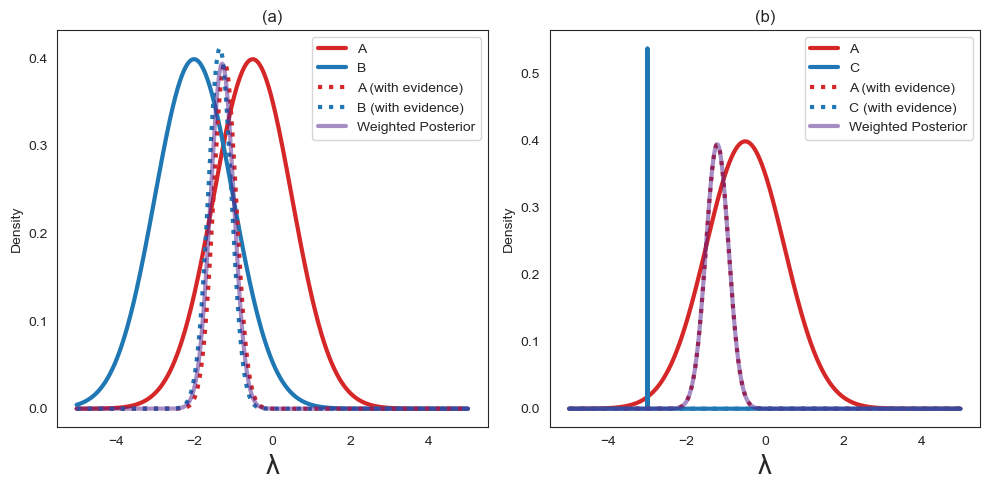

In [437]:
fig=plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(lams,prior_highsens,lw=3,c=cm.tab10(3),label="A")
plt.plot(lams,prior_lowsens,c=cm.tab10(0),label="B",lw=3)
plt.xlabel("λ",fontsize=20)

plt.plot(lams,prior_highsens*allevidence,c=cm.tab10(3),ls=":",lw=3,label="A (with evidence)")
plt.plot(lams,prior_lowsens*allevidence,c=cm.tab10(0),ls=":",lw=3,label="B (with evidence)")

plt.plot(lams,weight_lowsens2*prior_lowsens*allevidence+weight_highsens2*prior_highsens*allevidence,c=cm.Purples(.9),\
        lw=3,label="Weighted Posterior",alpha=.5)
plt.legend()
plt.ylabel("Density")
plt.title("(a)")

plt.subplot(122)
allevidence=normlam(proc*alpha_gaussian*historical_patterneffect_gaussian_prior)
plt.plot(lams,prior_highsens,lw=3,c=cm.tab10(3),label="A")
plt.plot(lams,stubbornprior/100,c=cm.tab10(0),label="C",lw=3)
plt.xlabel("λ",fontsize=20)

plt.plot(lams,prior_highsens*allevidence,c=cm.tab10(3),ls=":",lw=3,label="A (with evidence)")
plt.plot(lams,stubbornprior*allevidence/100,c=cm.tab10(0),ls=":",lw=3,label="C (with evidence)")

plt.plot(lams,weight_stubborn*stubbornprior*allevidence+weight_highsens*prior_highsens*allevidence,c=cm.Purples(.9),\
        lw=3,label="Weighted Posterior",alpha=.5)
plt.legend()
plt.ylabel("Density")
plt.tight_layout()
plt.title("(b)")
plt.savefig("FIGS/Priors_Posteriors_weighted_average.png")